## Implementing simple chatbot using Langgraph

In [48]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [49]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [50]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY') #type: ignore

In [51]:
from langchain_groq import ChatGroq

llm=ChatGroq(model='deepseek-r1-distill-llama-70b')

In [52]:
response=llm.invoke("Hello")
print(response.content)

<think>

</think>

Hello! How can I assist you today? 😊


### Start with creating nodes

In [53]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

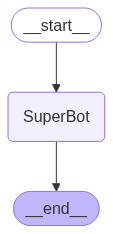

In [54]:
graph=StateGraph(State)

#Nodes

graph.add_node("SuperBot",superbot)

# Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)

graph_builder=graph.compile()

## Display

from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [55]:
graph_builder.invoke({'messages':'Hi, my name is Rishav and I like cricket'}) # type: ignore

{'messages': [HumanMessage(content='Hi, my name is Rishav and I like cricket', additional_kwargs={}, response_metadata={}, id='370df27e-3145-487a-a9c7-3daf01df2a4b'),
  AIMessage(content="<think>\nAlright, Rishav likes cricket. I should acknowledge his interest and ask a follow-up question to keep the conversation going.\n\nMaybe I can ask him which format he prefers or who his favorite team or player is. That should help me understand his interests better and provide a more tailored response.\n</think>\n\nHi Rishav! It's nice to meet you. Cricket is a fantastic sport—so many exciting moments and great players. Do you have a favorite team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 15, 'total_tokens': 113, 'completion_time': 0.45671421, 'prompt_time': 0.010629368, 'queue_time': 0.047573872, 'total_time': 0.467343578}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'service_tier': 

## Streaming the responses

In [56]:
for event in graph_builder.stream({'messages':'hi i am rishav'},stream_mode='values'): # type: ignore
    print(event)

{'messages': [HumanMessage(content='hi i am rishav', additional_kwargs={}, response_metadata={}, id='fd54ca9c-ab9f-4cf9-bdbc-1ad49fbef4d8')]}
{'messages': [HumanMessage(content='hi i am rishav', additional_kwargs={}, response_metadata={}, id='fd54ca9c-ab9f-4cf9-bdbc-1ad49fbef4d8'), AIMessage(content='<think>\n\n</think>\n\nHi Rishav! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 9, 'total_tokens': 28, 'completion_time': 0.089963708, 'prompt_time': 0.0100044, 'queue_time': 0.04759173, 'total_time': 0.099968108}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3e657525-3337-4d8d-8487-2fb747923c36-0', usage_metadata={'input_tokens': 9, 'output_tokens': 19, 'total_tokens': 28})]}


## Pydantic Data Validations

In [57]:
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel

In [58]:
class State(BaseModel):
    name:str

In [59]:
#node function
def example_node(state:State):
    return {'name':'Hello '+state.name}

In [60]:
## Stategraph

builder=StateGraph(State)
builder.add_node('example',example_node)

builder.add_edge(START,"example")
builder.add_edge('example',END)

graph=builder.compile()

In [61]:
graph.invoke({"name":"Rishav"}) # type: ignore

{'name': 'Hello Rishav'}

## Tools--Integrated with LLM models to interact with external systems

In [62]:
## Tool --> Internal/external functions / database / apis --> External Data / Third party agent

## sunction name + docstring (what the tool/function does)

## Tool
def add(a:int, b:int)-> int:
    """
    Add a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [63]:
## Binding tool with llm
from langchain_core.messages import HumanMessage,AIMessage

llm_with_tools=llm.bind_tools([add])

response=llm_with_tools.invoke([HumanMessage(content=f"Hey what is 2 plus 2",name="Rishav")])

print(response.tool_calls) # type: ignore

[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': '849d3wf2p', 'type': 'tool_call'}]


In [64]:
### Using messages as states

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    message:Annotated[list[AnyMessage],add_messages]


## Reducers with add_messages

In [65]:
initial_messages = [AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Rishav"))

In [66]:
## Reducer add_messages appends in place of overring --> vvi

ai_message=AIMessage(content=f"Which programing language you want to learn?",name='LLMModel')
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='c031fbb9-89e2-4b4f-ad47-5ea101ff4e8d'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Rishav', id='e63e6127-912f-4b41-b2ba-9c32f9043d4e'),
 AIMessage(content='Which programing language you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='2d1b042d-760a-4e17-be09-558b1e61d926')]

In [67]:
## chatbot node functionality

def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["message"])]}



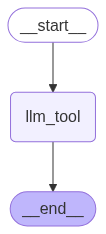

In [68]:
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END

builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,'llm_tool')
builder.add_edge('llm_tool',END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [71]:
## invocation

messages=graph.invoke({"message":"What is 2 plus 2"})
for message in messages['message']:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2


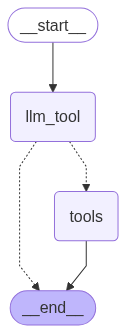

In [72]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder=StateGraph(State)
tools=[add]

## Add nodes

builder.add_node('llm_tool',llm_tool)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'llm_tool')
builder.add_conditional_edges('llm_tool',tools_condition)

builder.add_edge('tools',END)

graph_builder=builder.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))